In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ninzaami_loan_predication_path = kagglehub.dataset_download('ninzaami/loan-predication')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.graph_objects as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-predication/train_u6lujuX_CVtuZ9i (1).csv


In [ ]:
#In my project, I effectively demonstrate a structured approach to data preprocessing and visualization for a loan prediction problem.

In [ ]:
df=pd.read_csv('/kaggle/input/loan-predication/train_u6lujuX_CVtuZ9i (1).csv')

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
df.info()

In [ ]:
numeric_variable=[5,6,7,8]
categoric_variable=[0,1,2,3,4,9,10,11]
df.drop('Loan_ID',axis=1,inplace=True)
categoric_variable_2=[np.array(df.iloc[:,i].value_counts().index) for i in categoric_variable]

In [ ]:
#transformation
data=df.astype('str')
for j in range(len(categoric_variable)):
    if any(data[data.columns[categoric_variable[j]]].apply(lambda x:x[0].isnumeric())):
        for i in categoric_variable_2[j]:
            df.loc[df.iloc[:,categoric_variable[j]]==i,df.columns[categoric_variable[j]]]=str(i)[0]
    else:
        unique=np.flip(categoric_variable_2[j])
        for i in range(0,len(unique)):
            df.loc[df.iloc[:,categoric_variable[j]]==unique[i],df.columns[categoric_variable[j]]]=i

In [ ]:
#Trying to find the purest class distribution by dividing Featrue into thresholds
def find_min_index(value,indexs):
    new_list=sorted(value)
    for i in range(0,len(value)):
         if value[i]==new_list[0]:
            return indexs[i]
def find_max_index(value,indexs):
    new_list=sorted(value)
    for i in range(0,len(value)):
         if value[i]==new_list[-1]:
            return indexs[i]
#A version of the above objective with the gini index:
def calculate_gini(x_data,x_train):
    class_first=x_data.loc[x_train[x_train.iloc[:,-1]==x_train.iloc[:,-1].value_counts().index[0]].index]
    class_second=x_data.loc[x_train[x_train.iloc[:,-1]==x_train.iloc[:,-1].value_counts().index[1]].index]
    unique=x_data[0].value_counts().index
    gini_list=[]
    for i in range(0,len(unique)):
        first_class_rate=np.square((len(class_first[class_first.iloc[:,0]==unique[i]]))/(len(x_data[x_data.iloc[:,0]==unique[i]])))
        second_class_rate=np.square((len(class_second[class_second.iloc[:,0]==unique[i]]))/(len(x_data[x_data.iloc[:,0]==unique[i]])))
        gini_list.append((1-first_class_rate-second_class_rate)*(len(x_data[x_data==unique[i]])/len(x_data)))

    return sum(gini_list)
def split_numeric_feature(x_train,indis):
    gini_list_threshold=[]
    gini_threshold=[]
    x_data=pd.DataFrame(np.full(len(x_train),1),index=x_train.index)
    std=math.ceil((np.std(x_train.iloc[:,indis])))
    for i in range(math.ceil(np.min(x_train.iloc[:,indis])),math.floor(np.max(x_train.iloc[:,indis])),200):
        if (len(x_train.loc[x_train.iloc[:,indis]>i])<10) or (len(x_train.loc[x_train.iloc[:,indis]<=i])<10):
            continue
        else:
            x_data[0]=['Upper' if j>=i else 'Lower' for j in x_train.iloc[:,indis]]
            value_gini=calculate_gini(x_data,x_train)
            gini_list_threshold.append(value_gini)
            gini_threshold.append(i)
    result=find_min_index(gini_list_threshold,gini_threshold)
    return result
threshold_list=[]
data2=df.dropna(axis=0)
for i in range(5,9):
    threshold_list.append(split_numeric_feature(data2,i))
threshold_list=dict(zip(numeric_variable,threshold_list))

In [ ]:
def fill_nan(data,feature,threshold_list):
    nan_result=[]
    condition=[]
    for j in df[df[df.columns[feature]].isnull()].index:
        if feature in numeric_variable:
            corr_=df.corr().iloc[:,feature]
            new_corr=sorted(corr_)
            corr_list=[]
            for i in range(len(corr_)):
                if (corr_.values[i] in new_corr[7:]) and (corr_.values[i]!=1):
                    corr_list.append(i)
            for i in corr_list:
                if i in numeric_variable:
                    if df.iloc[j,i]>threshold_list[i]:
                        nan_result.append(df.loc[df.iloc[:,i]>threshold_list[i]].index)
                    else:
                        nan_result.append(df.loc[df.iloc[:,i]<=threshold_list[i]].index)
                else:
                     nan_result.append(df.loc[df.iloc[:,i]==df.iloc[j,i]].index)
            lngth=len(nan_result)
            nan_result_1=[nan_result[i][j] for i in range(len(nan_result)) for j in range(len(nan_result[i]))]
            counted=Counter(list(nan_result_1))
            for m in counted:
                if counted[m]==lngth:
                    condition.append(m)
            df.loc[j,df.columns[feature]]=np.mean(df.loc[condition,df.columns[feature]])
            nan_result=[]
        else:
            df.loc[j,df.columns[feature]]=(df.loc[:,df.columns[feature]]).mode()[0]


In [ ]:
nan_feature=[]
is_na=df.isna().sum()
for i in range(len(is_na)):
    if is_na[i]!=0:
        nan_feature.append(i)
for j in nan_feature:
    fill_nan(df,j,threshold_list)

In [ ]:
#Normalization
df.iloc[:,numeric_variable]=(np.array(df.iloc[:,numeric_variable])-np.min(np.array(df.iloc[:,numeric_variable]),axis=0))/(np.max(np.array(df.iloc[:,numeric_variable]),axis=0)-np.min(np.array(df.iloc[:,numeric_variable]),axis=0))

In [ ]:
#Data Visualization----------------->

In [ ]:
def plot_bar(feature,name):
    data=go.Bar(
                x=feature.value_counts().index,
                y=feature.value_counts().values,
                marker=dict(color='rgb(23,44,123)')
               )
    layout=go.Layout(
                title='The Graphic Of Categoric Feature',
                xaxis=dict(title='{}'.format(name)),
                yaxis=dict(title='Frequency')
               )
    figure=go.Figure(data=[data],layout=layout)
    iplot(figure)

In [ ]:
for i in range(0,len(categoric_variable)):
    plot_bar(df.iloc[:,categoric_variable[i]],df.columns[categoric_variable[i]])

In [ ]:
def plot_hist(feature,name):
    data=go.Histogram(
                x=feature.value_counts().index,
                y=feature.value_counts().values,
                marker=dict(color='rgb(45,100,3)')
               )
    layout=go.Layout(
                title='The Graphic Of Numeric Feature',
                xaxis=dict(title='{}'.format(name)),
                yaxis=dict(title='Frequency')
               )
    figure=go.Figure(data=[data],layout=layout)
    iplot(figure)

In [ ]:
for i in range(0,len(numeric_variable)):
    plot_hist(df.iloc[:,numeric_variable[i]],df.columns[numeric_variable[i]])

In [ ]:
scatter_matrix = pd.plotting.scatter_matrix(df, figsize=(15, 15), diagonal='hist',alpha=0.5)
plt.show()

In [ ]:
#corr
figure_size = (14, 9)
fig, ax = plt.subplots(figsize=figure_size)
sns.heatmap(df.corr(),annot=True,ax=ax)

In [ ]:
sns.boxplot(x='Gender',y='ApplicantIncome',data=df)

In [ ]:
sns.boxplot(x='Married',y='ApplicantIncome',data=df)

In [ ]:
sns.boxplot(x='Dependents',y='ApplicantIncome',data=df)

In [ ]:
#Visualization of anomalies:
sns.boxplot(x='Education',y='ApplicantIncome',data=df)

In [ ]:
sns.boxplot(x='Self_Employed',y='ApplicantIncome',data=df)

In [ ]:
sns.lmplot(x = 'ApplicantIncome', y = 'LoanAmount', fit_reg = False, hue = 'Loan_Status', data = df)

In [ ]:
sns.lmplot(x = 'ApplicantIncome', y = 'CoapplicantIncome', fit_reg = False, hue = 'Loan_Status', data = df)

In [ ]:
'''NOTES:
-Lending has little to do with whether you are a man or a woman
The number of credits given to female graduates is 5 times higher than non-graduates
Number of credits given to male graduates is 2 times more than non-graduates
-If an ekek lives in a semi-urban area, he is not given a loan
-Whether a man is married and lives in a rural or urban area gives him the same chance of getting a loan or not
A married man is two-thirds more likely to receive a loan than a married man in the general category.
-Lending rate decreases as the number of dependents increases
'''

In [ ]:
#Proportion of women and men receiving loans:
female_rate=100*len(df[(df['Gender']==df['Gender'].value_counts().index[1])&(df['Loan_Status']==1)])/(len(df[df['Gender']==df['Gender'].value_counts().index[1]]))
male_rate=100*len(df[(df['Gender']==df['Gender'].value_counts().index[0])&(df['Loan_Status']==1)])/(len(df[df['Gender']==df['Gender'].value_counts().index[0]]))
#Proportion of (women and graduates) and (women and !graduates) receiving loans:
female_rate_1=100*len(df[(df['Gender']==df['Gender'].value_counts().index[1])&(df['Loan_Status']==1)&(df['Education']==0)])/(len(df[df['Gender']==df['Gender'].value_counts().index[1]]))
female_rate_2=100*len(df[(df['Gender']==df['Gender'].value_counts().index[1])&(df['Loan_Status']==1)&(df['Education']==1)])/(len(df[df['Gender']==df['Gender'].value_counts().index[1]]))
male_rate_1=100*len(df[(df['Gender']==df['Gender'].value_counts().index[0])&(df['Loan_Status']==1)&(df['Education']==0)])/(len(df[df['Gender']==df['Gender'].value_counts().index[0]]))
male_rate_2=100*len(df[(df['Gender']==df['Gender'].value_counts().index[0])&(df['Loan_Status']==1)&(df['Education']==1)])/(len(df[df['Gender']==df['Gender'].value_counts().index[0]]))
#Married and rural men vs Married and urban men vs Married and semi-urban men:
male_rate_12=100*len(df[(df['Gender']==df['Gender'].value_counts().index[0])&(df['Loan_Status']==1)&(df['Married']==0)&(df['Property_Area']==2)])/(len(df[df['Gender']==df['Gender'].value_counts().index[0]]))
male_rate_13=100*len(df[(df['Gender']==df['Gender'].value_counts().index[0])&(df['Loan_Status']==1)&(df['Married']==0)&(df['Property_Area']==1)])/(len(df[df['Gender']==df['Gender'].value_counts().index[0]]))
male_rate_14=100*len(df[(df['Gender']==df['Gender'].value_counts().index[0])&(df['Loan_Status']==1)&(df['Married']==0)&(df['Property_Area']==3)])/(len(df[df['Gender']==df['Gender'].value_counts().index[0]]))
male_rate_15=100*len(df[(df['Gender']==df['Gender'].value_counts().index[0])&(df['Loan_Status']==1)&(df['Married']==0)])/(len(df[df['Gender']==df['Gender'].value_counts().index[0]]))
#Change in credit rate as the number of dependents increases:
male_rate_16=100*len(df[(df['Dependents']==df['Dependents'].value_counts().index[0])&(df['Loan_Status']==1)])/(len(df))
male_rate_17=100*len(df[(df['Dependents']==df['Dependents'].value_counts().index[1])&(df['Loan_Status']==1)])/(len(df))
male_rate_18=100*len(df[(df['Dependents']==df['Dependents'].value_counts().index[2])&(df['Loan_Status']==1)])/(len(df))
male_rate_19=100*len(df[(df['Dependents']==df['Dependents'].value_counts().index[3])&(df['Loan_Status']==1)])/(len(df))

print(male_rate_16)
print(male_rate_17)
print(male_rate_18)
print(male_rate_19)

In [ ]:
class_name=[]
percent_list=np.array([])
rate_list=[]
for j in categoric_variable:
    sayac=0
    while True:
        percent_list=np.append(percent_list,[100*len(df[(df.iloc[:,j]==df.iloc[:,j].value_counts().index[sayac])&(df['Loan_Status']==1)])/(len(df[df.iloc[:,j]==df.iloc[:,j].value_counts().index[sayac]]))])
        class_name.append(df.iloc[:,j].value_counts().index[sayac])
        sayac+=1
        if sayac==len(df.iloc[:,j].value_counts().index):
            break
    rate_list.append(percent_list)
    percent_list=[]
print(rate_list)

In [ ]:
#Status of features according to whether a loan is granted or not:
def loan_rate(df,rate_list,categoric_variable,catcategoric_variable_2):
    trace1=go.Bar(
                x=catcategoric_variable_2,
                y=rate_list,
                marker=dict(color='rgb(45,100,3)')
               )
    layout=go.Layout(
                title='The Graphic Of Numeric Feature',
                xaxis=dict(title='{}'.format(df.columns[categoric_variable])),
                yaxis=dict(title='Frequency')
               )
    figure=go.Figure(data=[trace1],layout=layout)
    iplot(figure)


for i in range(len(categoric_variable)-1):
    loan_rate(df,rate_list[i],categoric_variable[i],categoric_variable_2[i])


In [ ]:
#Histogram distribution in each featurette according to the unique values in the class column, i.e. whether or not they received a loan
def plot_displot(numerical_variable):
    g=sns.FaceGrid(df,col='Loan_Status')
    g.map(sns.distplot,df[df.columns[indis]],bins=25)
    plt.show()

In [ ]:
#DATA VISUALTİON OVER-----------------<

In [ ]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,1,1,0.070489,0.000000,0.211318,0.74359,1,1,1
1,1,1,1,1,1,0.054830,0.036192,0.172214,0.74359,1,0,0
2,1,1,0,1,0,0.035250,0.000000,0.082489,0.74359,1,1,1
3,1,1,0,0,1,0.030093,0.056592,0.160637,0.74359,1,1,1
4,1,0,0,1,1,0.072356,0.000000,0.191027,0.74359,1,1,1


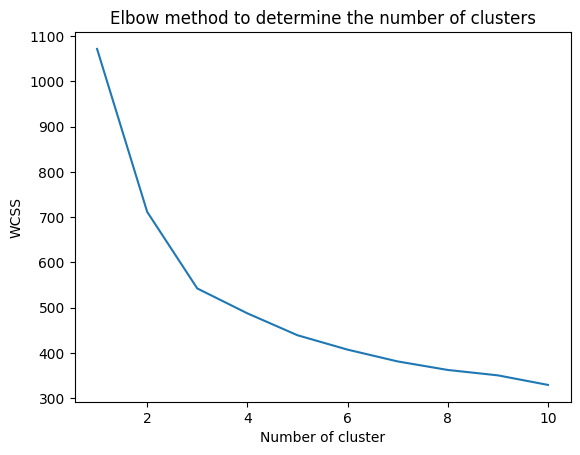

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
df.iloc[:,list(range(5))+list(range(9,12))]=df.iloc[:,list(range(5))+list(range(9,12))].astype(int)
x=df.loc[:,df.columns[0:11]]
y=df.iloc[:,11]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)
y_test=y_test.astype(int)
wcss = []
number_of_cluster = range(1,11)
for i in number_of_cluster :
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x_train.values)
    wcss.append(kmeans.inertia_)

plt.plot(number_of_cluster, wcss)
plt.title('Elbow method to determine the number of clusters')
plt.xlabel('Number of cluster')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 500, n_init =10, random_state = 0)
y_kmeans = kmeans.fit_predict(x_train.values)
x_train['Cluster']=y_kmeans

"x_train.iloc[:,[11,12]]=x_train.iloc[:,[12,11]]\ndf=df.rename(columns={'Loan_Status':'temp','Cluster':'Loan_Status', 'temp':'Cluster'})\ndf=df.rename(columns={'temp':'Cluster'})"

In [ ]:
x_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Cluster
553,1,1,0,0,1,0.028497,0.055992,0.248915,0.743590,0,1,3
601,1,1,0,0,1,0.033939,0.067007,0.211288,0.743590,1,0,3
261,1,0,0,1,1,0.023624,0.053016,0.180897,0.743590,1,2,4
496,1,1,0,0,1,0.030303,0.040800,0.141823,0.743590,1,0,3
529,1,0,0,0,1,0.082041,0.000000,0.175109,0.743590,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,1,2,0,0,0.021336,0.045000,0.127352,0.743590,1,2,2
106,1,1,2,1,1,0.139357,0.027024,0.312590,0.743590,1,1,2
270,0,0,0,1,1,0.038182,0.000000,0.030391,0.743590,1,1,0
435,0,1,0,1,1,0.122412,0.000000,0.211131,0.487179,1,2,4


In [ ]:
ref=[]
#Create a representative sample for each cluster
for j in x_train['Cluster'].value_counts().index:
    cluster=x_train.loc[x_train['Cluster']==j]
    ref.append([cluster.iloc[:,0].mode()[0],cluster.iloc[:,1].mode()[0],
               cluster.iloc[:,2].mode()[0],cluster.iloc[:,3].mode()[0],cluster.iloc[:,4].mode()[0],
               np.mean(cluster.iloc[:,5]),np.mean(cluster.iloc[:,6]),np.mean(cluster.iloc[:,7]),
               np.mean(cluster.iloc[:,8]),cluster.iloc[:,9].mode()[0],cluster.iloc[:,10].mode()[0]])
for j in ref:
    print(j)

[1, 1, 0, 1, 1, 0.06443446278032744, 0.03618882327136872, 0.1907252399153425, 0.702117694282792, 1, 2]
[1, 1, 0, 1, 1, 0.05975262832405689, 0.04597291793094227, 0.20795217993216916, 0.6782468877053783, 1, 1]
[1, 0, 0, 1, 1, 0.05723223488529611, 0.03214402856205721, 0.1733127985292351, 0.7293780222126198, 1, 1]
[1, 1, 2, 1, 1, 0.06721161191749427, 0.03509894273356401, 0.21017236176591825, 0.6851432880844646, 1, 1]
[1, 1, 2, 1, 1, 0.11103045763760049, 0.04162616699066408, 0.2567836468885673, 0.6971153846153846, 1, 0]


In [ ]:
def find_min_index_(value):
    new_list=sorted(value)
    for i in range(0,len(value)):
         if value[i]==new_list[0]:
            return i

In [ ]:
#Choosing the most appropriate classification algorithm for each cluster of the clustered data
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
accuracy_list=[]
classifier_list=[]#Her clusterin algosu
classifer=[0,1,2,3,4]
cluster=x_train['Cluster'].value_counts().index
for j in cluster:
    x_train_1=x_train.loc[x_train['Cluster']==j,x_train.columns[:11]]
    y_train_1=y_train.loc[x_train_1.index]
    y_train_1=y_train_1.astype(int)
    #SVM
    svm =SVC(kernel='linear')  # Lineer bir SVM modeli oluşturuluyor
    svm.fit(x_train_1,y_train_1)
    y_pred = svm.predict(x_train_1)
    accuracy_list.append(accuracy_score(y_train_1,y_pred))
    #random forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)  # n_estimators: Oluşturulacak ağaç sayısı, random_state: Rastgelelik seviyesi
    clf.fit(x_train_1,y_train_1)
    y_pred=clf.predict(x_train_1)
    accuracy_list.append(accuracy_score(y_train_1,y_pred))
    #Logistic regression
    logistic_regression = LogisticRegression()
    logistic_regression.fit(x_train_1,y_train_1)
    y_pred = logistic_regression.predict(x_train_1)
    accuracy_list.append(accuracy_score(y_train_1,y_pred))
    #decision
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x_train_1, y_train_1)
    y_pred= decision_tree.predict(x_train_1)
    accuracy_list.append(accuracy_score(y_train_1,y_pred))
    #naive
    naive_bayes = GaussianNB()  # Örnek olarak Gaussian Naive Bayes kullanıldı
    naive_bayes.fit(x_train_1,y_train_1)
    y_pred=naive_bayes.predict(x_train_1)
    accuracy_list.append(accuracy_score(y_train_1,y_pred))
    print(accuracy_list)
    classifier_list.append(find_max_index(accuracy_list,classifer))
    accuracy_list=[]
print(classifier_list)
def predict_test(sample,ref,x_test):
    distance=[]
    for j in ref:
        distance.append(np.sum(np.square(np.array(j)-x_test.loc[sample,df.columns[:11]].values)))
    return find_min_index_(distance)
def predict(classifier,sample,x_train,y_train,cluster):
    data=x_train.loc[x_train['Cluster']==cluster,x_train.columns[:11]]
    data_y=y_train.loc[data.index]
    data_y=data_y.astype(int)
    if classifier==0:
        svm =SVC(kernel='linear')  # Lineer bir SVM modeli oluşturuluyor
        svm.fit(data.values,data_y)
        y_pred = svm.predict(sample)
    elif classifier==1:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)  # n_estimators: Oluşturulacak ağaç sayısı, random_state: Rastgelelik seviyesi
        clf.fit(data.values, data_y)
        y_pred=clf.predict(sample)
    elif classifier==2:
        logistic_regression = LogisticRegression()
        logistic_regression.fit(data.values,data_y)
        y_pred = logistic_regression.predict(sample)
    elif classifier==3:
        decision_tree = DecisionTreeClassifier()
        decision_tree.fit(data.values,data_y)
        y_pred= decision_tree.predict(sample)
    else:
        naive_bayes = GaussianNB()  # Örnek olarak Gaussian Naive Bayes kullanıldı
        naive_bayes.fit(data.values, data_y)
        y_pred=naive_bayes.predict(sample)
    return y_pred

[0.8721804511278195, 1.0, 0.8646616541353384, 1.0, 0.8721804511278195]
[0.7857142857142857, 1.0, 0.7857142857142857, 1.0, 0.8035714285714286]
[0.7142857142857143, 1.0, 0.7142857142857143, 1.0, 0.7023809523809523]
[0.8676470588235294, 1.0, 0.8529411764705882, 1.0, 0.8529411764705882]
[0.875, 1.0, 0.875, 1.0, 0.84375]
[1, 1, 1, 1, 1]


In [ ]:
y_head=[]
for i in x_test.index:
    index_=predict_test(i,ref,x_test)
    print(index_)
    y_head.append(predict(classifier_list[index_],np.array(x_test.loc[i,:]).reshape(1,-1),x_train,y_train,cluster[index_]))
accuracy = accuracy_score(y_test,y_head)
print("Doğruluk skoru:", accuracy)

0
0
4
2
2
4
3
1
4
1
3
1
3
4
3
1
2
2
0
0
1
3
0
0
2
2
4
2
2
4
3
0
0
2
2
1
1
3
3
3
2
1
4
1
2
3
3
1
1
2
0
0
1
2
1
4
2
3
4
3
3
0
4
1
3
2
3
0
3
1
2
1
0
4
3
0
4
4
2
0
1
3
3
2
1
0
3
3
1
1
3
2
0
0
0
4
2
3
2
2
0
0
2
1
3
4
1
3
2
2
2
2
1
4
1
2
1
1
1
2
0
3
1
0
0
3
0
2
1
3
4
0
2
0
3
1
1
1
4
0
1
3
2
3
2
1
2
2
1
2
3
0
3
2
3
2
3
2
3
2
2
2
1
3
0
0
2
4
3
4
2
2
3
0
1
0
0
4
0
1
0
4
3
1
1
Doğruluk skoru: 0.7135135135135136
